In [17]:
import random

import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from model import KGCN
from data_loader import DataLoader

In [18]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use, sum, concat, or neighbor')
parser.add_argument('--mixer', type=str, default='attention', help='which mixer to use, attention or transe?')
parser.add_argument('--n_epochs', type=int, default=20, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

arguments = '--dataset product --mixer transe --n_epochs 100 --batch_size=16 --l2_weight 1e-4'
args = parser.parse_args(arguments.split())

In [19]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


/home/ssc/coding/KGCN-pytorch/data_loader.py:95: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, group in df_dataset.groupby(['userID']):


,userID,itemID,label
0,153,1219,0
1,153,389,1
2,141,1220,1
3,22,706,0
4,141,1310,1
...,...,...,...
572,141,181,0
573,141,953,1
574,141,389,0
575,711,1488,1


In [20]:
# Dataset class - This class is used to create a dataset object from the given dataframe
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

In [21]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_dataset, df_dataset['label'],  # x are triplets; a triplet is (user, item, label)
    test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [22]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()  # binary cross entropy loss
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

device:  cuda


In [23]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients of all the parameters in the optimizer to zero
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()  # Calculate the gradients of the parameters
        
        optimizer.step()  # Update the parameters using the gradients

        running_loss += loss.item()
    
    # Print train loss
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # Evaluate
    with torch.no_grad():  # Disabling gradient calculation
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:  # For each row in the data
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

[Epoch 1]train_loss:  1.002461868113485
[Epoch 1]test_loss:  0.846653938293457
[Epoch 2]train_loss:  0.8599015279062863
[Epoch 2]test_loss:  0.7796855419874191
[Epoch 3]train_loss:  0.7650765483749324
[Epoch 3]test_loss:  0.7316655740141869
[Epoch 4]train_loss:  0.6959093768021156
[Epoch 4]test_loss:  0.6958095915615559
[Epoch 5]train_loss:  0.6421577642703878
[Epoch 5]test_loss:  0.6681265383958817
[Epoch 6]train_loss:  0.5983041416982124
[Epoch 6]test_loss:  0.6461563631892204
[Epoch 7]train_loss:  0.5613234222962938
[Epoch 7]test_loss:  0.6283168792724609
[Epoch 8]train_loss:  0.529422779021592
[Epoch 8]test_loss:  0.613547783344984
[Epoch 9]train_loss:  0.5014658395586342
[Epoch 9]test_loss:  0.6011129580438137
[Epoch 10]train_loss:  0.4766880633502171
[Epoch 10]test_loss:  0.5904867202043533
[Epoch 11]train_loss:  0.4545393098017265
[Epoch 11]test_loss:  0.5812877342104912
[Epoch 12]train_loss:  0.4345967648872014
[Epoch 12]test_loss:  0.5732371658086777
[Epoch 13]train_loss:  0.4

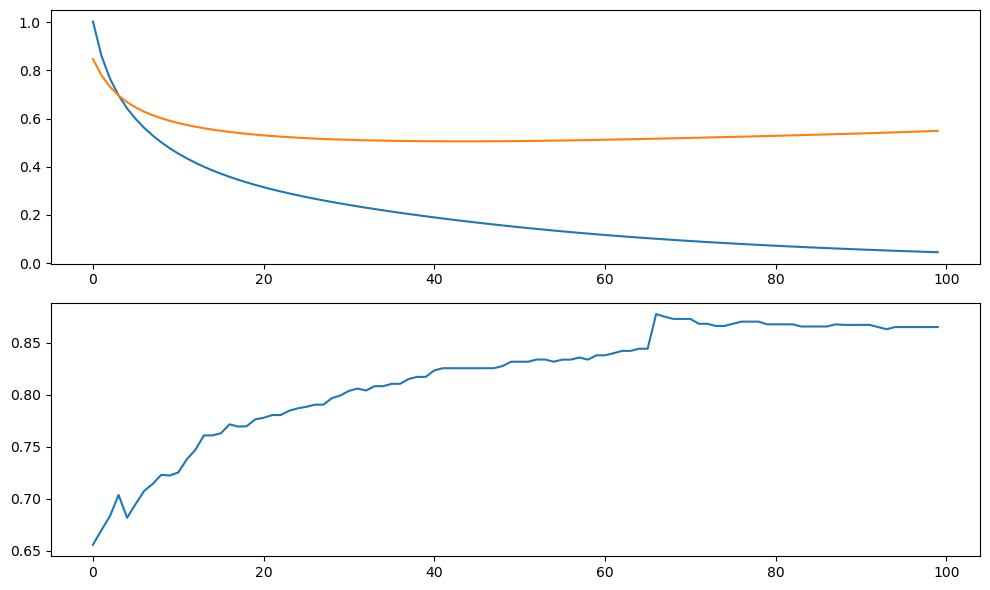

In [24]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,6))
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)

plt.tight_layout()